In [88]:
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

In [89]:
df = pd.read_csv('./data/FPT Historical Data.csv')

In [90]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/29/2024,"109,000.0","108,200.0","109,400.0","107,700.0",2.82M,0.46%
1,02/28/2024,"108,500.0","108,000.0","108,500.0","106,300.0",3.46M,0.56%
2,02/27/2024,"107,900.0","108,500.0","109,500.0","107,400.0",2.80M,-0.09%
3,02/26/2024,"108,000.0","103,900.0","108,000.0","103,500.0",4.47M,3.95%
4,02/23/2024,"103,900.0","105,500.0","106,700.0","103,300.0",4.10M,-0.67%


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      3032 non-null   object
 1   Price     3032 non-null   object
 2   Open      3032 non-null   object
 3   High      3032 non-null   object
 4   Low       3032 non-null   object
 5   Vol.      3032 non-null   object
 6   Change %  3032 non-null   object
dtypes: object(7)
memory usage: 165.9+ KB


In [4]:
df["Date"] = pd.to_datetime(df.Date,format="%m/%d/%Y")
df.set_index("Date", inplace=True)

df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)

In [5]:
df.shape

(3032, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3032 entries, 2024-02-29 to 2012-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     3032 non-null   float64
 1   Open      3032 non-null   float64
 2   High      3032 non-null   float64
 3   Low       3032 non-null   float64
 4   Vol.      3032 non-null   object 
 5   Change %  3032 non-null   object 
dtypes: float64(4), object(2)
memory usage: 165.8+ KB


In [7]:
df.describe()

,Price,Open,High,Low
count,3032.00000,3032.000000,3032.000000,3032.000000
mean,33815.07091,33807.178529,34175.549604,33463.277704
std,28572.51074,28560.187845,28884.081480,28246.986747
min,5840.90000,5786.900000,5876.800000,5769.000000
25%,12752.20000,12751.025000,12997.500000,12611.200000
50%,22024.30000,22068.250000,22208.600000,21882.800000
75%,52755.75000,52685.500000,53229.900000,52334.050000
max,109000.00000,108500.000000,109500.000000,107700.000000


In [9]:
df.interpolate()

C:\Users\hieu\AppData\Local\Temp\ipykernel_5116\4002874584.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate()


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-02-29,109000.0,108200.0,109400.0,107700.0,2.82M,0.46%
2024-02-28,108500.0,108000.0,108500.0,106300.0,3.46M,0.56%
2024-02-27,107900.0,108500.0,109500.0,107400.0,2.80M,-0.09%
2024-02-26,108000.0,103900.0,108000.0,103500.0,4.47M,3.95%
2024-02-23,103900.0,105500.0,106700.0,103300.0,4.10M,-0.67%
...,...,...,...,...,...,...
2012-01-09,6742.5,6714.9,6742.5,6659.6,219.83K,0.41%
2012-01-06,6714.9,6701.1,6714.9,6673.4,315.30K,0.83%
2012-01-05,6659.6,6673.4,6756.3,6645.8,309.57K,-2.03%


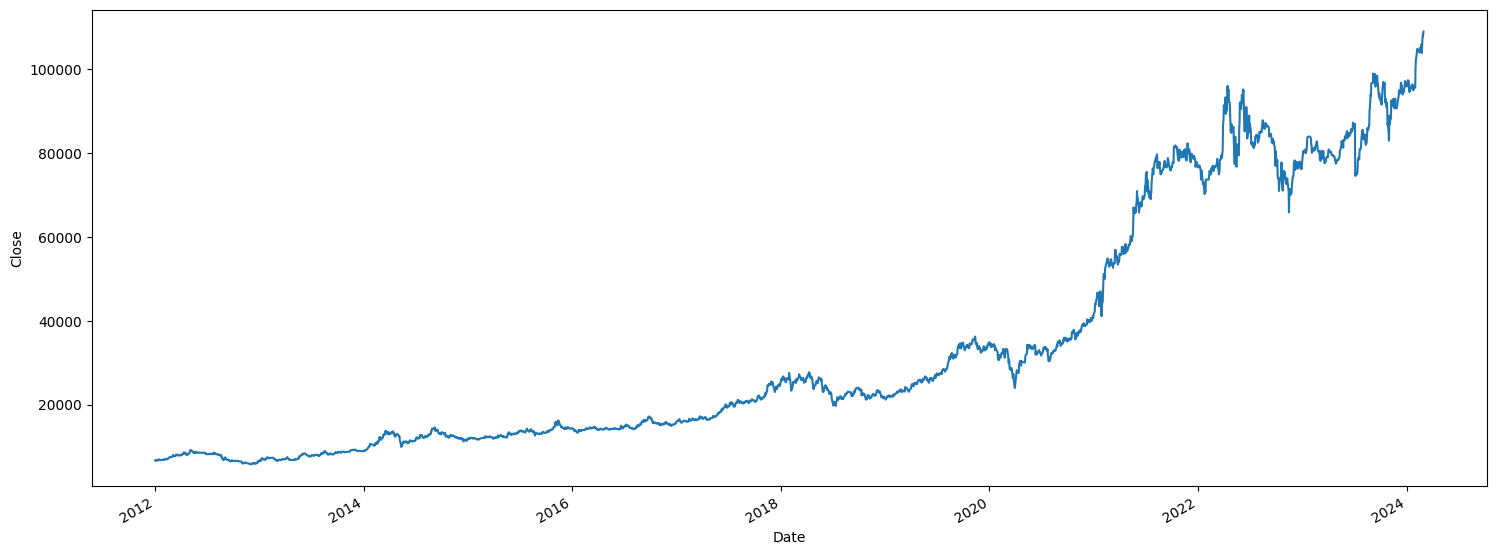

In [86]:
fig, ax = plt.subplots(figsize=(18, 7))
df['Price'].plot()
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.show()

In [87]:
import re

print(df['Vol.'].apply(type))

# Hàm chuyển đổi giá trị từ chuỗi thành số float
def convert_to_float(x):
    # Tách lấy phần số
    number_part = re.findall(r'\d*\.?\d+', x)[0]
    # Tách lấy phần đơn vị
    unit_part = re.sub(r'\d*\.?\d+', '', x)

    # Chuyển đổi đơn vị thành hệ số
    if unit_part == 'K':
        multiplier = 1000
    elif unit_part == 'M':
        multiplier = 1000000
    elif unit_part == 'B':
        multiplier = 1000000000
    else:
        multiplier = 1

    # Trả về giá trị số đã được chuyển đổi
    return float(number_part) * multiplier

# Áp dụng hàm chuyển đổi cho cột 'col'
df['Vol.'] = df['Vol.'].apply(convert_to_float)

# Hiển thị DataFrame sau khi chuyển đổi
print(df)

Date
2024-02-29    <class 'float'>
2024-02-28    <class 'float'>
2024-02-27    <class 'float'>
2024-02-26    <class 'float'>
2024-02-23    <class 'float'>
                   ...       
2012-01-09    <class 'float'>
2012-01-06    <class 'float'>
2012-01-05    <class 'float'>
2012-01-04    <class 'float'>
2012-01-03    <class 'float'>
Name: Vol., Length: 3032, dtype: object


TypeError: expected string or bytes-like object, got 'float'

In [ ]:
features = ['Open', 'High', 'Low', 'Vol.']

scaler = MinMaxScaler()
X = scaler.fit_transform(df[features])
X = pd.DataFrame(columns=features, data=X, index=df.index)  # Thêm index=df.index
X.head()

,Open,High,Low,Vol.
Date,,,,
2024-02-29,0.997079,0.999035,1.000000,0.230518
2024-02-28,0.995132,0.990350,0.986265,0.283188
2024-02-27,1.000000,1.000000,0.997057,0.228872
2024-02-26,0.955215,0.985524,0.958796,0.366309
2024-02-23,0.970792,0.972979,0.956834,0.335859


In [ ]:
y = pd.DataFrame(df['Price'])

timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X):
        X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
from sklearn.model_selection import train_test_split

y = pd.DataFrame(df['Price'])

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)
y_train, y_test = train_test_split(y.values.ravel(), test_size=0.3, random_state=42)

In [ ]:
X_train

,Open,High,Low,Vol.
Date,,,,
2013-05-16,0.014044,0.013053,0.013418,0.039063
2016-07-08,0.092298,0.094014,0.093182,0.301294
2023-01-12,0.732264,0.729790,0.730210,0.043085
2014-08-22,0.070201,0.069924,0.069689,0.451898
2017-12-05,0.190859,0.190398,0.186145,0.586043
...,...,...,...,...
2017-08-08,0.148920,0.147357,0.146504,0.239571
2019-10-11,0.272306,0.270196,0.272819,0.102134
2019-08-22,0.254338,0.255258,0.252377,0.245331


In [ ]:
X_test

,Open,High,Low,Vol.
Date,,,,
2020-12-28,0.339648,0.340542,0.339673,0.247800
2023-02-20,0.738105,0.744266,0.741982,0.103780
2020-12-02,0.319814,0.320884,0.322444,0.237925
2014-02-26,0.059351,0.062585,0.059042,0.697968
2016-09-07,0.098343,0.096612,0.097153,0.251915
...,...,...,...,...
2019-09-03,0.250860,0.253535,0.252960,0.176202
2019-11-14,0.294331,0.293752,0.279244,0.625546
2017-12-01,0.188336,0.187481,0.187839,0.300471


In [ ]:
model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
model.fit(X_train, y_train)
predict = model.predict(X_test)

print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(X_train, y_train) * 100:.2f}% and Test Score : {model.score(X_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 264.6745
Mean Squared Error: 289010.4301
Root Mean Squared Error: 537.5969
(R^2) Score: 0.9997
Train Score : 100.00% and Test Score : 99.97% using Random Tree Regressor.
Accuracy: 99.3 %.


In [ ]:
result_df = df.copy()
result_df['Price'] = model.predict(X)

result_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-02-29,107752.4,108200.0,109400.0,107700.0,2820000.0,0.46%
2024-02-28,108063.4,108000.0,108500.0,106300.0,3460000.0,0.56%
2024-02-27,107694.8,108500.0,109500.0,107400.0,2800000.0,-0.09%
2024-02-26,107310.8,103900.0,108000.0,103500.0,4470000.0,3.95%
2024-02-23,104613.0,105500.0,106700.0,103300.0,4100000.0,-0.67%


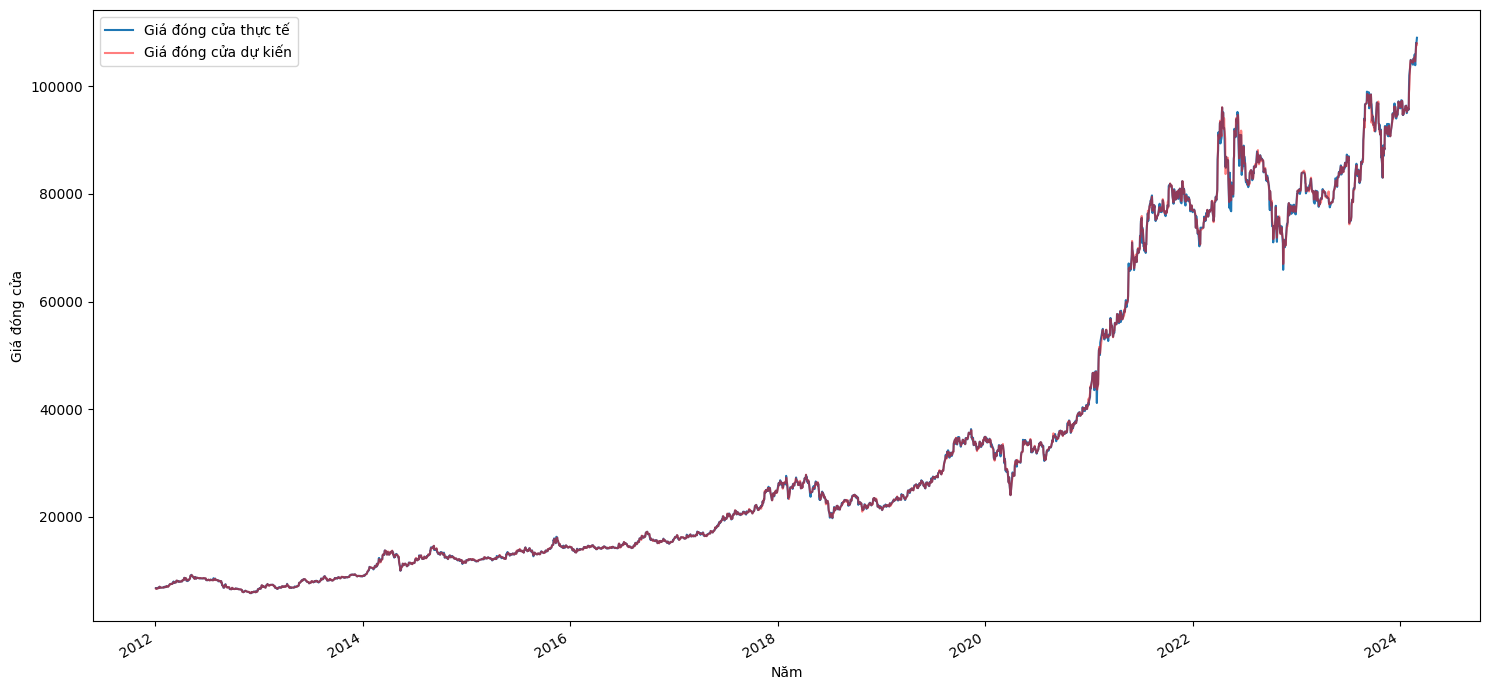

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
df['Price'].plot(alpha=1, label = 'Giá đóng cửa thực tế')
ax.plot(result_df['Price'], color='red', alpha=0.5, label = 'Giá đóng cửa dự kiến')
ax.set_xlabel('Năm')
ax.set_ylabel('Giá đóng cửa')
plt.legend(loc='best')
plt.tight_layout()
plt.show()